Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}")


DOLFINx version: 0.8.0


1: Total tims is  69.79 s
2: Total numb steps is  14


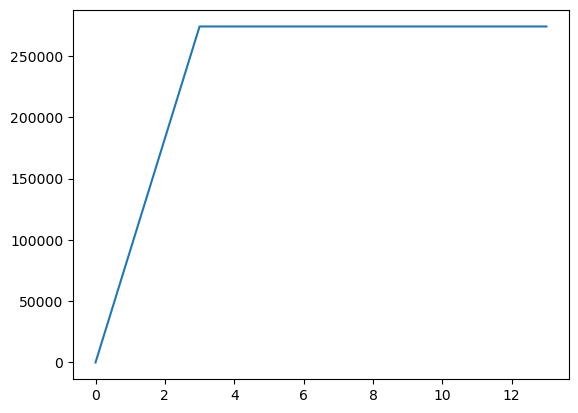

In [2]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions
from brake_disc_functions import *

# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 10
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 11200
v_vehicle = 160
c_acc = 1

# calling local functions to get all parameters
(
    dt,
    P,
    g,
    num_steps,
    h,
    radiation,
    v_angular,
    Ti,
    Tm,
    S_rub_circle,
    t,
    rho,
    c,
    k,
    t_brake,
    S_total,
) = vehicle_initial(angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)
plt.plot(P)

## 2: Mesh

In [3]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-10.msh' exists, start creat now:
Info    : Reading 'm-3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading 'm-3-10.msh'



## 3: Setup 


In [4]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [5]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)
    + radiation * inner(u**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-05-15 13:40:53.533 (  15.208s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:40:53.646 (  15.321s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:40:53.666 (  15.342s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0290838 (tol = 1e-10) r (rel) = 4.67493e-06(tol = 1e-06)
2024-05-15 13:40:53.717 (  15.393s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:40:53.758 (  15.434s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.07792e-07 (tol = 1e-10) r (rel) = 1.73265e-11(tol = 1e-06)
2024-05-15 13:40:53.760 (  15.435s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.


## 5: Solution


In [6]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * 25 * v * ds(200)
            + radiation * (25**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 11200 degree. 2: Current time is 2.0 s. 3: Completion is 4.1 %. 

2024-05-15 13:40:56.993 (  18.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:40:56.994 (  18.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:40:56.994 (  18.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-15 13:40:56.994 (  18.669s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:40:56.995 (  18.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:40:56.995 (  18.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-15 13:40:56.995 (  18.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:40:56.996 (  18.671s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 4.1 %. 

2024-05-15 13:41:08.178 (  29.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:08.178 (  29.853s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:08.179 (  29.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:08.179 (  29.854s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:08.184 (  29.859s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:08.203 (  29.878s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:41:08.246 (  29.921s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:08.364 (  30.039s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22400 degree. 2: Current time is 4.1 s. 3: Completion is 8.4 %. 

2024-05-15 13:41:08.491 (  30.166s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.68385e-10 (tol = 1e-10) r (rel) = 1.18865e-11(tol = 1e-06)
2024-05-15 13:41:08.491 (  30.166s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:41:08.491 (  30.166s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:41:08.750 (  30.425s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:41:08.751 (  30.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:41:08.751 (  30.426s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-15 13:41:08.752 (  30.427s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 8.4 %. 

2024-05-15 13:41:21.427 (  43.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:21.427 (  43.102s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:21.429 (  43.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:21.429 (  43.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:21.433 (  43.108s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:21.451 (  43.126s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:41:21.490 (  43.165s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:21.588 (  43.263s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33600 degree. 2: Current time is 6.3 s. 3: Completion is 12.9 %. 

2024-05-15 13:41:21.630 (  43.305s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0372248 (tol = 1e-10) r (rel) = 2.46199e-05(tol = 1e-06)
2024-05-15 13:41:21.673 (  43.348s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:21.697 (  43.372s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.0036e-07 (tol = 1e-10) r (rel) = 1.32515e-10(tol = 1e-06)
2024-05-15 13:41:21.698 (  43.373s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 16 linear solver iterations.
2024-05-15 13:41:21.699 (  43.374s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:41:21.776 (  43.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:41:21.777 (  43.452s) [main            ]topologycomputation.cp

1: Completion is 12.9 %. 

2024-05-15 13:41:32.735 (  54.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:32.735 (  54.410s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:32.736 (  54.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:32.736 (  54.411s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:32.738 (  54.415s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:32.759 (  54.434s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:41:32.799 (  54.474s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:32.903 (  54.578s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44800 degree. 2: Current time is 8.7 s. 3: Completion is 17.7 %. 

2024-05-15 13:41:33.004 (  54.679s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.51169e-06 (tol = 1e-10) r (rel) = 5.11874e-10(tol = 1e-06)
2024-05-15 13:41:33.005 (  54.680s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 16 linear solver iterations.
2024-05-15 13:41:33.007 (  54.682s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:41:33.065 (  54.740s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:41:33.068 (  54.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:41:33.068 (  54.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-05-15 13:41:33.068 (  54.743s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Completion is 17.7 %. 

2024-05-15 13:41:43.772 (  65.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:43.772 (  65.447s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:43.774 (  65.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:43.774 (  65.449s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:43.777 (  65.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:43.792 (  65.467s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0


1: Rotation has applied for 56000 degree. 2: Current time is 11.1 s. 3: Completion is 22.7 %. 

2024-05-15 13:41:43.841 (  65.516s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:44.334 (  66.009s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:44.356 (  66.031s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 3.29994 (tol = 1e-10) r (rel) = 0.000740418(tol = 1e-06)
2024-05-15 13:41:44.387 (  66.062s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:44.409 (  66.084s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 1.66802e-05 (tol = 1e-10) r (rel) = 3.74259e-09(tol = 1e-06)
2024-05-15 13:41:44.409 (  66.084s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:41:44.410 (  66.085s) [main            ]      xdmf_functio

1: Completion is 22.7 %. 

2024-05-15 13:41:55.000 (  76.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:55.000 (  76.675s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:55.001 (  76.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:55.001 (  76.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:41:55.004 (  76.680s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:41:55.020 (  76.695s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:41:55.058 (  76.735s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 67200 degree. 2: Current time is 13.7 s. 3: Completion is 28.0 %. 

2024-05-15 13:41:55.271 (  76.946s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:55.303 (  76.978s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 13.4885 (tol = 1e-10) r (rel) = 0.00294015(tol = 1e-06)
2024-05-15 13:41:55.340 (  77.015s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:41:55.362 (  77.038s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.000446417 (tol = 1e-10) r (rel) = 9.73077e-08(tol = 1e-06)
2024-05-15 13:41:55.364 (  77.039s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:41:55.364 (  77.039s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:41:55.452 (  77.127s) [main            ]topologycomputat

1: Completion is 28.0 %. 

2024-05-15 13:42:06.051 (  87.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:06.051 (  87.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:06.053 (  87.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:06.053 (  87.728s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:06.054 (  87.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:06.074 (  87.749s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:42:06.109 (  87.785s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:06.299 (  87.975s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 78400 degree. 2: Current time is 16.6 s. 3: Completion is 33.8 %. 

2024-05-15 13:42:06.357 (  88.032s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:06.385 (  88.060s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.00147227 (tol = 1e-10) r (rel) = 3.08212e-07(tol = 1e-06)
2024-05-15 13:42:06.385 (  88.060s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:42:06.385 (  88.060s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:42:06.471 (  88.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:42:06.471 (  88.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:42:06.471 (  88.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)

1: Completion is 33.8 %. 

2024-05-15 13:42:16.982 (  98.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:16.986 (  98.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:16.987 (  98.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:16.987 (  98.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:16.991 (  98.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:17.008 (  98.683s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:42:17.042 (  98.717s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:17.178 (  98.853s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 89600 degree. 2: Current time is 19.6 s. 3: Completion is 40.0 %. 

2024-05-15 13:42:17.249 (  98.924s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:17.269 (  98.953s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.000738588 (tol = 1e-10) r (rel) = 1.59909e-07(tol = 1e-06)
2024-05-15 13:42:17.278 (  98.953s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:42:17.288 (  98.963s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:42:17.374 (  99.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:42:17.374 (  99.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:42:17.374 (  99.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 40.0 %. 

2024-05-15 13:42:28.396 ( 110.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:28.396 ( 110.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:28.397 ( 110.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:28.397 ( 110.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:28.398 ( 110.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:28.421 ( 110.097s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:42:28.455 ( 110.130s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.


1: Rotation has applied for 100800 degree. 2: Current time is 23.0 s. 3: Completion is 46.9 %. 

2024-05-15 13:42:28.609 ( 110.284s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:28.637 ( 110.313s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 14.5349 (tol = 1e-10) r (rel) = 0.00242062(tol = 1e-06)
2024-05-15 13:42:28.670 ( 110.345s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:28.693 ( 110.368s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.000418423 (tol = 1e-10) r (rel) = 6.96835e-08(tol = 1e-06)
2024-05-15 13:42:28.693 ( 110.368s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:42:28.694 ( 110.369s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:42:28.791 ( 110.466s) [main            ]topologycomputat

1: Completion is 46.9 %. 

2024-05-15 13:42:39.488 ( 121.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:39.488 ( 121.163s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:39.492 ( 121.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:39.492 ( 121.167s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:39.497 ( 121.172s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:39.518 ( 121.194s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:42:39.553 ( 121.228s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:39.646 ( 121.330s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 112000 degree. 2: Current time is 26.8 s. 3: Completion is 54.7 %. 

2024-05-15 13:42:39.684 ( 121.359s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 19.2511 (tol = 1e-10) r (rel) = 0.00186788(tol = 1e-06)
2024-05-15 13:42:39.735 ( 121.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:39.760 ( 121.435s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.00150873 (tol = 1e-10) r (rel) = 1.46388e-07(tol = 1e-06)
2024-05-15 13:42:39.760 ( 121.435s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:42:39.762 ( 121.437s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:42:39.826 ( 121.501s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:42:39.827 ( 121.502s) [main            ]topologycomputation.cpp:7

1: Completion is 54.7 %. 

2024-05-15 13:42:50.366 ( 132.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:50.369 ( 132.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:50.373 ( 132.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:50.373 ( 132.048s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:42:50.378 ( 132.053s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:42:50.395 ( 132.070s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:42:50.427 ( 132.102s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:50.565 ( 132.240s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 123200 degree. 2: Current time is 31.3 s. 3: Completion is 63.8 %. 

2024-05-15 13:42:50.634 ( 132.309s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:50.653 ( 132.328s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.307737 (tol = 1e-10) r (rel) = 4.41191e-05(tol = 1e-06)
2024-05-15 13:42:50.665 ( 132.356s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:42:50.705 ( 132.380s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 4: r (abs) = 1.55405e-06 (tol = 1e-10) r (rel) = 2.22799e-10(tol = 1e-06)
2024-05-15 13:42:50.705 ( 132.380s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 4 iterations and 20 linear solver iterations.
2024-05-15 13:42:50.706 ( 132.381s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:42:50.782 ( 132.457s) [main            ]topologycomput

1: Completion is 63.8 %. 

2024-05-15 13:43:01.114 ( 142.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:01.123 ( 142.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:01.124 ( 142.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:01.124 ( 142.799s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:01.128 ( 142.803s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:01.144 ( 142.819s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:43:01.176 ( 142.851s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:01.290 ( 142.966s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 134400 degree. 2: Current time is 36.8 s. 3: Completion is 75.2 %. 

2024-05-15 13:43:01.393 ( 143.068s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.514952 (tol = 1e-10) r (rel) = 9.79226e-05(tol = 1e-06)
2024-05-15 13:43:01.431 ( 143.106s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:01.452 ( 143.127s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 4: r (abs) = 6.32594e-06 (tol = 1e-10) r (rel) = 1.20293e-09(tol = 1e-06)
2024-05-15 13:43:01.452 ( 143.127s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 4 iterations and 20 linear solver iterations.
2024-05-15 13:43:01.453 ( 143.128s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:43:01.544 ( 143.219s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:43:01.544 ( 143.219s) [main            ]topologycomputation.cp

1: Completion is 75.2 %. 

2024-05-15 13:43:12.038 ( 153.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:12.039 ( 153.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:12.041 ( 153.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:12.041 ( 153.716s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:12.045 ( 153.720s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:12.062 ( 153.737s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:43:12.097 ( 153.772s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:12.224 ( 153.899s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 145600 degree. 2: Current time is 45.0 s. 3: Completion is 91.8 %. 

2024-05-15 13:43:12.224 ( 153.899s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 13.7978 (tol = 1e-10) r (rel) = 0.00355292(tol = 1e-06)
2024-05-15 13:43:12.292 ( 153.967s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:12.321 ( 154.003s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.000435183 (tol = 1e-10) r (rel) = 1.1206e-07(tol = 1e-06)
2024-05-15 13:43:12.331 ( 154.006s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:43:12.331 ( 154.006s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:43:12.417 ( 154.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:43:12.417 ( 154.092s) [main            ]topologycomputation.cpp:7

1: Completion is 91.8 %. 

2024-05-15 13:43:23.186 ( 164.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:23.187 ( 164.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:23.188 ( 164.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:23.188 ( 164.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:23.192 ( 164.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:23.213 ( 164.888s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:43:23.245 ( 164.921s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:23.352 ( 165.027s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 156800 degree. 2: Current time is 69.8 s. 3: Completion is 142.4 %. 

2024-05-15 13:43:23.412 ( 165.087s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:23.445 ( 165.120s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 0.000268894 (tol = 1e-10) r (rel) = 8.07593e-08(tol = 1e-06)
2024-05-15 13:43:23.445 ( 165.120s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-05-15 13:43:23.446 ( 165.121s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-05-15 13:43:23.535 ( 165.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:43:23.535 ( 165.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-05-15 13:43:23.535 ( 165.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0

1: Completion is 142.4 %. 

2024-05-15 13:43:34.137 ( 175.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:34.137 ( 175.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:34.138 ( 175.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:34.138 ( 175.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-05-15 13:43:34.142 ( 175.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-05-15 13:43:34.161 ( 175.836s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-05-15 13:43:34.196 ( 175.871s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-05-15 13:43:34.397 ( 176.072s) [main            ]              petsc.cpp:700   INFO| PETS


t and T have been successfully saved as Result_T-s-14-d-11200-m-3-10-c-1-e-43604.csv


# 6: Post process

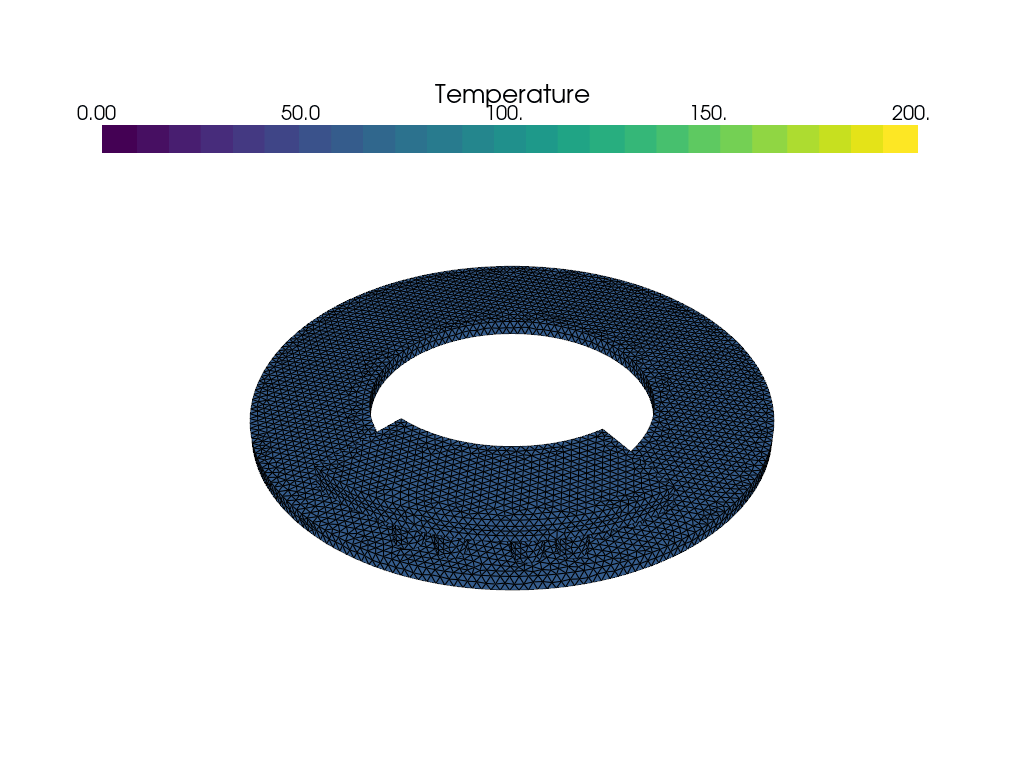

1: Start at: 2024-05-15 13:40:38
2: End at: 2024-05-15 13:43:35
3: Simulation time is 0 hours 3 minutes
4: First time step dt is 2.02319 s
5: Convection heat transfer coefficient is 7.75e-05 W/mm2 K
6: Radiation is 3.6e-13 W/mm2 K-4
7: Each rotation degree is 11200 per time step or 31.1 circle
8: The first rotation degree is 48869.2
9: The mid rotation degree is 48869.2
10: The last rotation degree is 48869.2
11: Total contact area of 18 rubbing element is 199.9 cm2
12: The mesh element size is between 3-10 mm
13: Total elements number is 43604

Move files successfully


In [7]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
for filename in files_to_move:
    source_file_path = os.path.join(source_dir, filename)
    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
print("Move files successfully")

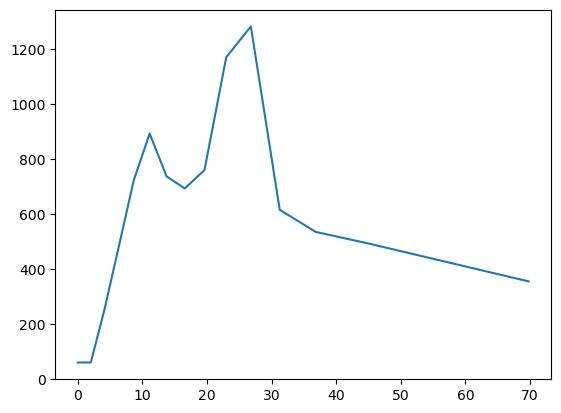

In [8]:
## get t and temperature T form T_array matrix
t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_max = []
for i in range(len(T)):
    T_max.append(max(T[i]))

plt.plot(t, T_max)

In [9]:
print(T_max)

[60, 60.02512177262961, 252.62612730972333, 480.3294681615535, 722.4001862919322, 892.14116368384, 736.4870544874957, 692.4939805619315, 759.3327873796754, 1169.5715721446215, 1281.3032979049713, 614.9262873084083, 534.53674258248, 492.4161748215961, 354.68607267210666]


Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]


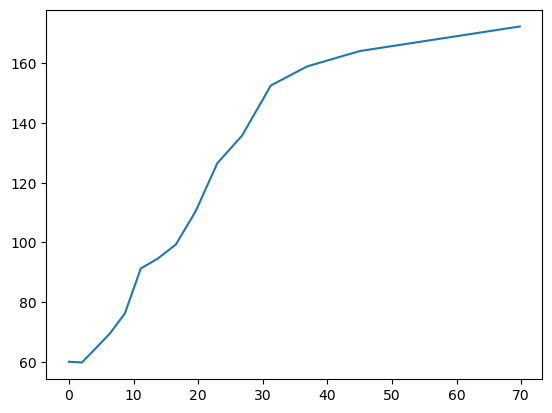

In [10]:
from brake_disc_functions import *

lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)

In [11]:
lables = find_3_coord(mesh_filename1)
# T_3_labels = 3157, 7018, 2141
# for i in range(len(T)):
#   print( T[i][T_3_labels[1]] )

Lables already exists, for mesh m-3-10.msh is  [3157, 7018, 2141]
